In [126]:
# Pricing an Modelisation of a Autocallable
# At the beginning we want a null value so we use it to determine C, L, H
import yfinance as yf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

In [136]:
#Stock
start = pd.to_datetime("2024-12-10")
end = pd.to_datetime(dt.datetime.now()).normalize() #pd.to_datetime("2025-02-22")
stock = yf.download("AAPL", start, end, auto_adjust= True)
stock_adj = stock["Close"]
stock_adj.asof(end) # On récupre le dernier jour ouvré

[*********************100%***********************]  1 of 1 completed


Ticker
AAPL    245.550003
Name: 2025-02-23 00:00:00, dtype: float64

In [255]:
N = 1000 #Notional
K = stock_adj.asof(start).item()  # Strike Price (Mettre prix début)
T = 3    # Maturity Date in year
t = 1    # Intermdediate Period in year
C = 0.03 # Coupon
H =1.1 # Barrier High
L = 0.9  # Barrier Low

In [256]:
Date_Observations = [start + pd.DateOffset(years=i) for i in range(t,T+1,t)]
len(Date_Observations)

3

In [257]:
def Coupons(N,K,T,t,C,H,L,stock_adj):
    Date_Observations = [start + pd.DateOffset(years=i) for i in range(t,T+1,t)]
    Coupons =[]
    for d in Date_Observations:
        if stock_adj.asof(d).item()/K > H:
            Coupons.append(N*(1+C))
            return Coupons
        if stock_adj.asof(d).item()/K > L and stock_adj.asof(d).item()/K < H:
            Coupons.append(N*C)
        else:
            Coupons.append(0)
    Coupons[-1] += N
    return Coupons
Coupons(N,K,T,t,C,H,L,stock_adj)

[30.0, 30.0, 1030.0]

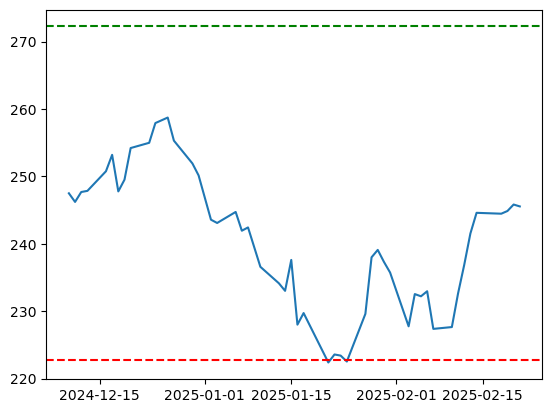

In [258]:
#Tracer avec seuilles et dates coupons 
plt.plot(stock_adj.index,stock_adj)
plt.axhline(y=H*K, color="green", linestyle="--", label=f"Seuil H = {H}")
plt.axhline(y=L*K, color="red", linestyle="--", label=f"Seuil L = {L}")
plt.show()

In [231]:
# Pricing with Monte Carlo

In [259]:
Z = np.random.randn(N) #Loie normale (0,1)
r = 0.0275   # rf
sigma = 0.2  # Volatilité (voir si historique ou prendre midèle dynamique
n = 100000 # Nb Simulations

In [262]:
# On fait des simulations des prix aux differentes périodes
S0 = stock_adj.iloc[-1].to_numpy() # Prix asset aujourd'hui
Q = [] # liste des coupons recue simule
for j in range(n):
    St = [S0]
    i = 1
    P = []
    y = 0
    while i < len(Date_Observations):
        x = St[-1] * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(t) * np.random.randn(1)) # Valeurs simulés
        St.append(x)
        if x/K >= H:
            P.append(N*(1+C))
            y = 1
            break
        if x/K > L and x/K < H:
            P.append(N*C)
            i+=1
        if x/K <= L:
            P.append(0)
            i+=1
    if y == 0:
        P.append(N)
    Q.append(P)
Q

[[30.0, 30.0, 1000],
 [1030.0],
 [0, 0, 1000],
 [30.0, 30.0, 1000],
 [30.0, 30.0, 1000],
 [1030.0],
 [0, 0, 1000],
 [0, 0, 1000],
 [30.0, 1030.0],
 [1030.0],
 [30.0, 0, 1000],
 [1030.0],
 [1030.0],
 [0, 1030.0],
 [1030.0],
 [1030.0],
 [30.0, 30.0, 1000],
 [1030.0],
 [30.0, 1030.0],
 [30.0, 1030.0],
 [30.0, 30.0, 1000],
 [0, 0, 1000],
 [30.0, 0, 1000],
 [0, 0, 1000],
 [0, 30.0, 1000],
 [1030.0],
 [30.0, 30.0, 1000],
 [1030.0],
 [30.0, 1030.0],
 [0, 0, 1000],
 [0, 1030.0],
 [30.0, 30.0, 1000],
 [30.0, 30.0, 1000],
 [0, 0, 1000],
 [0, 0, 1000],
 [1030.0],
 [1030.0],
 [30.0, 30.0, 1000],
 [1030.0],
 [1030.0],
 [0, 30.0, 1000],
 [30.0, 1030.0],
 [0, 0, 1000],
 [30.0, 30.0, 1000],
 [1030.0],
 [0, 0, 1000],
 [1030.0],
 [30.0, 30.0, 1000],
 [30.0, 1030.0],
 [1030.0],
 [30.0, 0, 1000],
 [0, 30.0, 1000],
 [1030.0],
 [30.0, 0, 1000],
 [1030.0],
 [30.0, 1030.0],
 [1030.0],
 [0, 30.0, 1000],
 [0, 0, 1000],
 [1030.0],
 [30.0, 1030.0],
 [30.0, 1030.0],
 [30.0, 30.0, 1000],
 [0, 0, 1000],
 [1030.0],
 

In [263]:
# On calcule les payoffs
Payoffs  = []
for i in range(len(Q)):
    x = 0
    for j in range (len(Q[i])):
        x += Q[i][j]/((1+r)**j)  # Discount les coupons pour les payoffs
    Payoffs.append(x)
Price_Autocallable = sum(Payoffs)/n - N
Price_Autocallable # We change the parameters to obtain 0 and depending on the wants of the client

1.9787778037597263